(qconv)=

# Сверточные вариационные квантовые схемы

Автор(ы):

- [Петров Вадим](https://github.com/belgraviton)


## Описание лекции

На этой лекции мы рассмотрим аналог сверточных слоев нейронной сети и приведем пример их использования. Лекция расскажет:
- как работают "классические" свертки в нейронных сетях;
- что такое сверточные вариационные квантовые схемы;
- как их можно использовать для задач машинного обучения на примере датасета MNIST.

## Сверточные нейронные сети

Данный тип нейронных сетей нацелен на обработку изображений и представляет из себя последовательный набор `сверточных слоев`, чередующиеся с другими вспомогательными слоями, например, с функциями нелинейного преобразования (активациями). Пример работы `сверточного слоя` представлен на рисунке ниже.

```{figure} /_static/qnn/ru/2D_Convolution_Animation.gif
:name: 2D_Convolution_Animation

Классическая свертка
```

Свое название `сверточный слой` получил из-за наличия операции свертки (конволюции), суть которой в том, что каждый фрагмент входного изображения (input) умножается на матрицу (ядро размера 3х3, kernel) свертки поэлементно, а результат суммируется и записывается в аналогичную позицию выходного изображения (output).

`Сверточные слои` являются ключевыми элементами алгоритмов по распознаванию и классификации изображений. Большинство успехов в области компьютерного зрения за последнее десятилетие связано именно с ними.

## Квантовая свертка

Активное развитие квантовых вычислений создает запрос на построение квантового аналога светки. Работа [(Henderson M. et.al., 2019)](https://arxiv.org/abs/1904.04767), описывающая подобный подход, предлагает следующую схему реализации на основе вариационных квантовых схем:
 - изображение разбивается на блоки размера 2х2;
 - для каждого блока осуществляется кодирование входного сигнала к квантовому состоянию, которое в данной лекции осуществляется параметризованным вращением кубита из основного состояния;
 - квантовые вычисления выполняются над входными кубитами посредством случайной квантовой цепи;
 - проводится измерение квантовой системы для получения классических величин;
 - выполняя данную процедуру для всех 2х2 областей на выходе получается многоканальное изображение (четырехканальное на примере ниже), которое будет использоваться в следующих слоях классической или квантовой нейронной сети.

```{figure} /_static/qnn/ru/qconv_net4.png
:name: qconv_net4
:width: 700px

Квантовая свертка
```

Основное отличие по отношению к классической свертке состоит в том, что квантовая схема может генерировать очень сложные ядра, вычисления которых могут быть классически невоспроизводимыми. Указанные сложные ядра, а именно ядра в высокоразмерном пространстве Гильберта, могут дать преимущества квантовым сверткам по отношению к классическим.

Пример реализации и работы такого блока квантовой свертки будет продемонстрирован ниже.

## Подготовка модели и данных

Пример кода реализации гибридной квантово-классической сети с квантовым сверточным слоем взят из [документации](https://pennylane.ai/qml/demos/tutorial_quanvolution.html) библиотеки `PennyLane` с небольшими изменениями.

Сначала загружаем библиотеки `PennyLane` для квантовых вычислений, `tensorflow` для обучения классификатора и `matplotlib` для отрисовки результатов.

In [1]:
import pennylane as qml
from pennylane import numpy as np
from pennylane.templates import RandomLayers

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import tensorflow as tf
from tensorflow import keras

import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

/home/runner/work/qmlcourse/qmlcourse/.venv/lib/python3.8/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


Устанавливаем параметры модели для обучения: число эпох, число слоев квантовой свертки и его выходных каналов, а также число тренировочных и тестовых примеров. Нужно использовать 4 кубита, для обработки каждого из 4 пикселей входного блока и генерации 4 каналов.  Число примеров выбрано малым для увеличения скорости демонстрации. Также фиксируем инициализацию генераторов случайных чисел для `numpy` и `tensorflow`.

In [2]:
n_epochs = 20   # Количество эпох обучения
n_layers = 1    # Число случайных квантовых блоков
n_wires = 4     # Число выходных каналов после квантовых блоков
n_train = 20    # Размер тренировочного датасета
n_test = 10     # Размер тестового датасета

# Инициализация генераторов случайных чисел
np.random.seed(0)  
tf.random.set_seed(255)  

Для демонстрации используем датасет MNIST, который создан для предсказания цифры (от 0 до  9) по его изображению

In [3]:
mnist_dataset = keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist_dataset.load_data()

# Ограничение размера датасета
train_images = train_images[:n_train]
train_labels = train_labels[:n_train]
test_images = test_images[:n_test]
test_labels = test_labels[:n_test]

# Нормализация изображений из диапазона (0, 255) в (0, 1)
train_images = train_images / 255
test_images = test_images / 255

# Добавление дополнительной размерности к данным для сверточных каналов
train_images = np.array(train_images[..., tf.newaxis], requires_grad=False)
test_images = np.array(test_images[..., tf.newaxis], requires_grad=False)

    8192/11490434 [..............................] - ETA: 0s

 8732672/11490434 [=====================>........] - ETA: 0s

11490434/11490434 [==============================] - 0s 0us/step


## Случайная квантовая цепь

В качестве блока квантовой свертки используется **случайная квантовая цепь** (RandomLayers в `PennyLane`). Блок реализуется путем случайного выбора для части кубитов операций вращения, а для части пар кубитов парных квантовых гейтов. На последнем этапе генерации блока осуществляется случайное перемешивание очередности применения операций.

В нашем примере случайная квантовая цепь обрабатывает 4 кубита. Таким образом часть из 4 кубитов получит какие-либо операции вращения, а часть из 6 пар кубитов - гейты. Финальная очередность операций будет случайной.

Следует заметить, что в нашем примере используется фиксированный (необучаемый) блок случайной квантовой цепи. Он будет использован как блок препроцессинга. В будущем, когда в библиотеке будет реализована возможность расчета градиентов и изменения параметров блока на их основании, указанный блок тоже можно будет обучать.

## Реализация квантовой свертки

Далее создаем устройство, симулирующее работу 4 кубитов. Оно состоит из трех частей:
- кодировщик, преобразующий входные данные в квантовые состояния с помощью $RY$ поворотов;
- случайная квантовая цепь;
- измерения, дающие 4 выходных значения.

In [4]:
dev = qml.device("default.qubit", wires=n_wires)

# Генерация значений параметров для квантовых слоев
rand_params = np.random.uniform(high=2 * np.pi, size=(n_layers, n_wires))

@qml.qnode(dev)
def circuit(phi):
    # Кодирование 4 классических входных данных
    for j in range(n_wires):
        qml.RY(np.pi * phi[j], wires=j)

    # Случайная квантовая цепь
    RandomLayers(rand_params, wires=list(range(n_wires)))

    # Измерения, которые дают 4 классических выходных значений для следующих слоев
    return [qml.expval(qml.PauliZ(j)) for j in range(n_wires)]

Следующая функция `quanv` определяет квантовую свертку по следующей схеме:
- разделение изображения на блоки 2х2 пикселей;
- обработку каждого блока квантовой цепью `circuit`, описанной выше;
- 4 выходных значения для каждого блока помещаются в 4 разных канала одного пикселя выходного изображения.

Описанный выше процесс уменьшает разрешение входного изображения в 2 раза, что эквивалентно классической свертки с ядром 2х2 и шагом 2

In [5]:
def quanv(image):
    """Функция квантовой свертки над входным изображением."""

    out = np.zeros((14, 14, n_wires))

    # Циклы по координатам верхнего левого пикселя блоков 2х2
    for j in range(0, 28, 2):
        for k in range(0, 28, 2):
            # Обработка блока 2x2 из изображения квантовой цепью
            q_results = circuit(
                [
                    image[j, k, 0],
                    image[j, k + 1, 0],
                    image[j + 1, k, 0],
                    image[j + 1, k + 1, 0]
                ]
            )
            # Запись результатов наблюдения в выходной пиксель (j/2, k/2)
            for c in range(n_wires):
                out[j // 2, k // 2, c] = q_results[c]
    return out

## Подготовка датасета

Так как квантовый сверточный слой в нашем случае не обучается, то лучше провести предварительную обработку им всех используемых изображений из датасета. Подготовленные данные будут использоваться классической нейронной сетью для обучения модели классификатора.

In [6]:
q_train_images = []
for idx, img in enumerate(train_images):
    q_train_images.append(quanv(img))
q_train_images = np.asarray(q_train_images)
print("Препроцессинг тренировочных изображений квантовой сверткой выполнен.")

q_test_images = []
for idx, img in enumerate(test_images):
    q_test_images.append(quanv(img))
q_test_images = np.asarray(q_test_images)
print("Препроцессинг тестовых изображений квантовой сверткой выполнен.")

Препроцессинг тренировочных изображений квантовой сверткой выполнен.


Препроцессинг тестовых изображений квантовой сверткой выполнен.


Давайте посмотрим на 4 первых тренировочных примера (первый ряд) и их 4 канала подготовленных данных (2-5 строки)

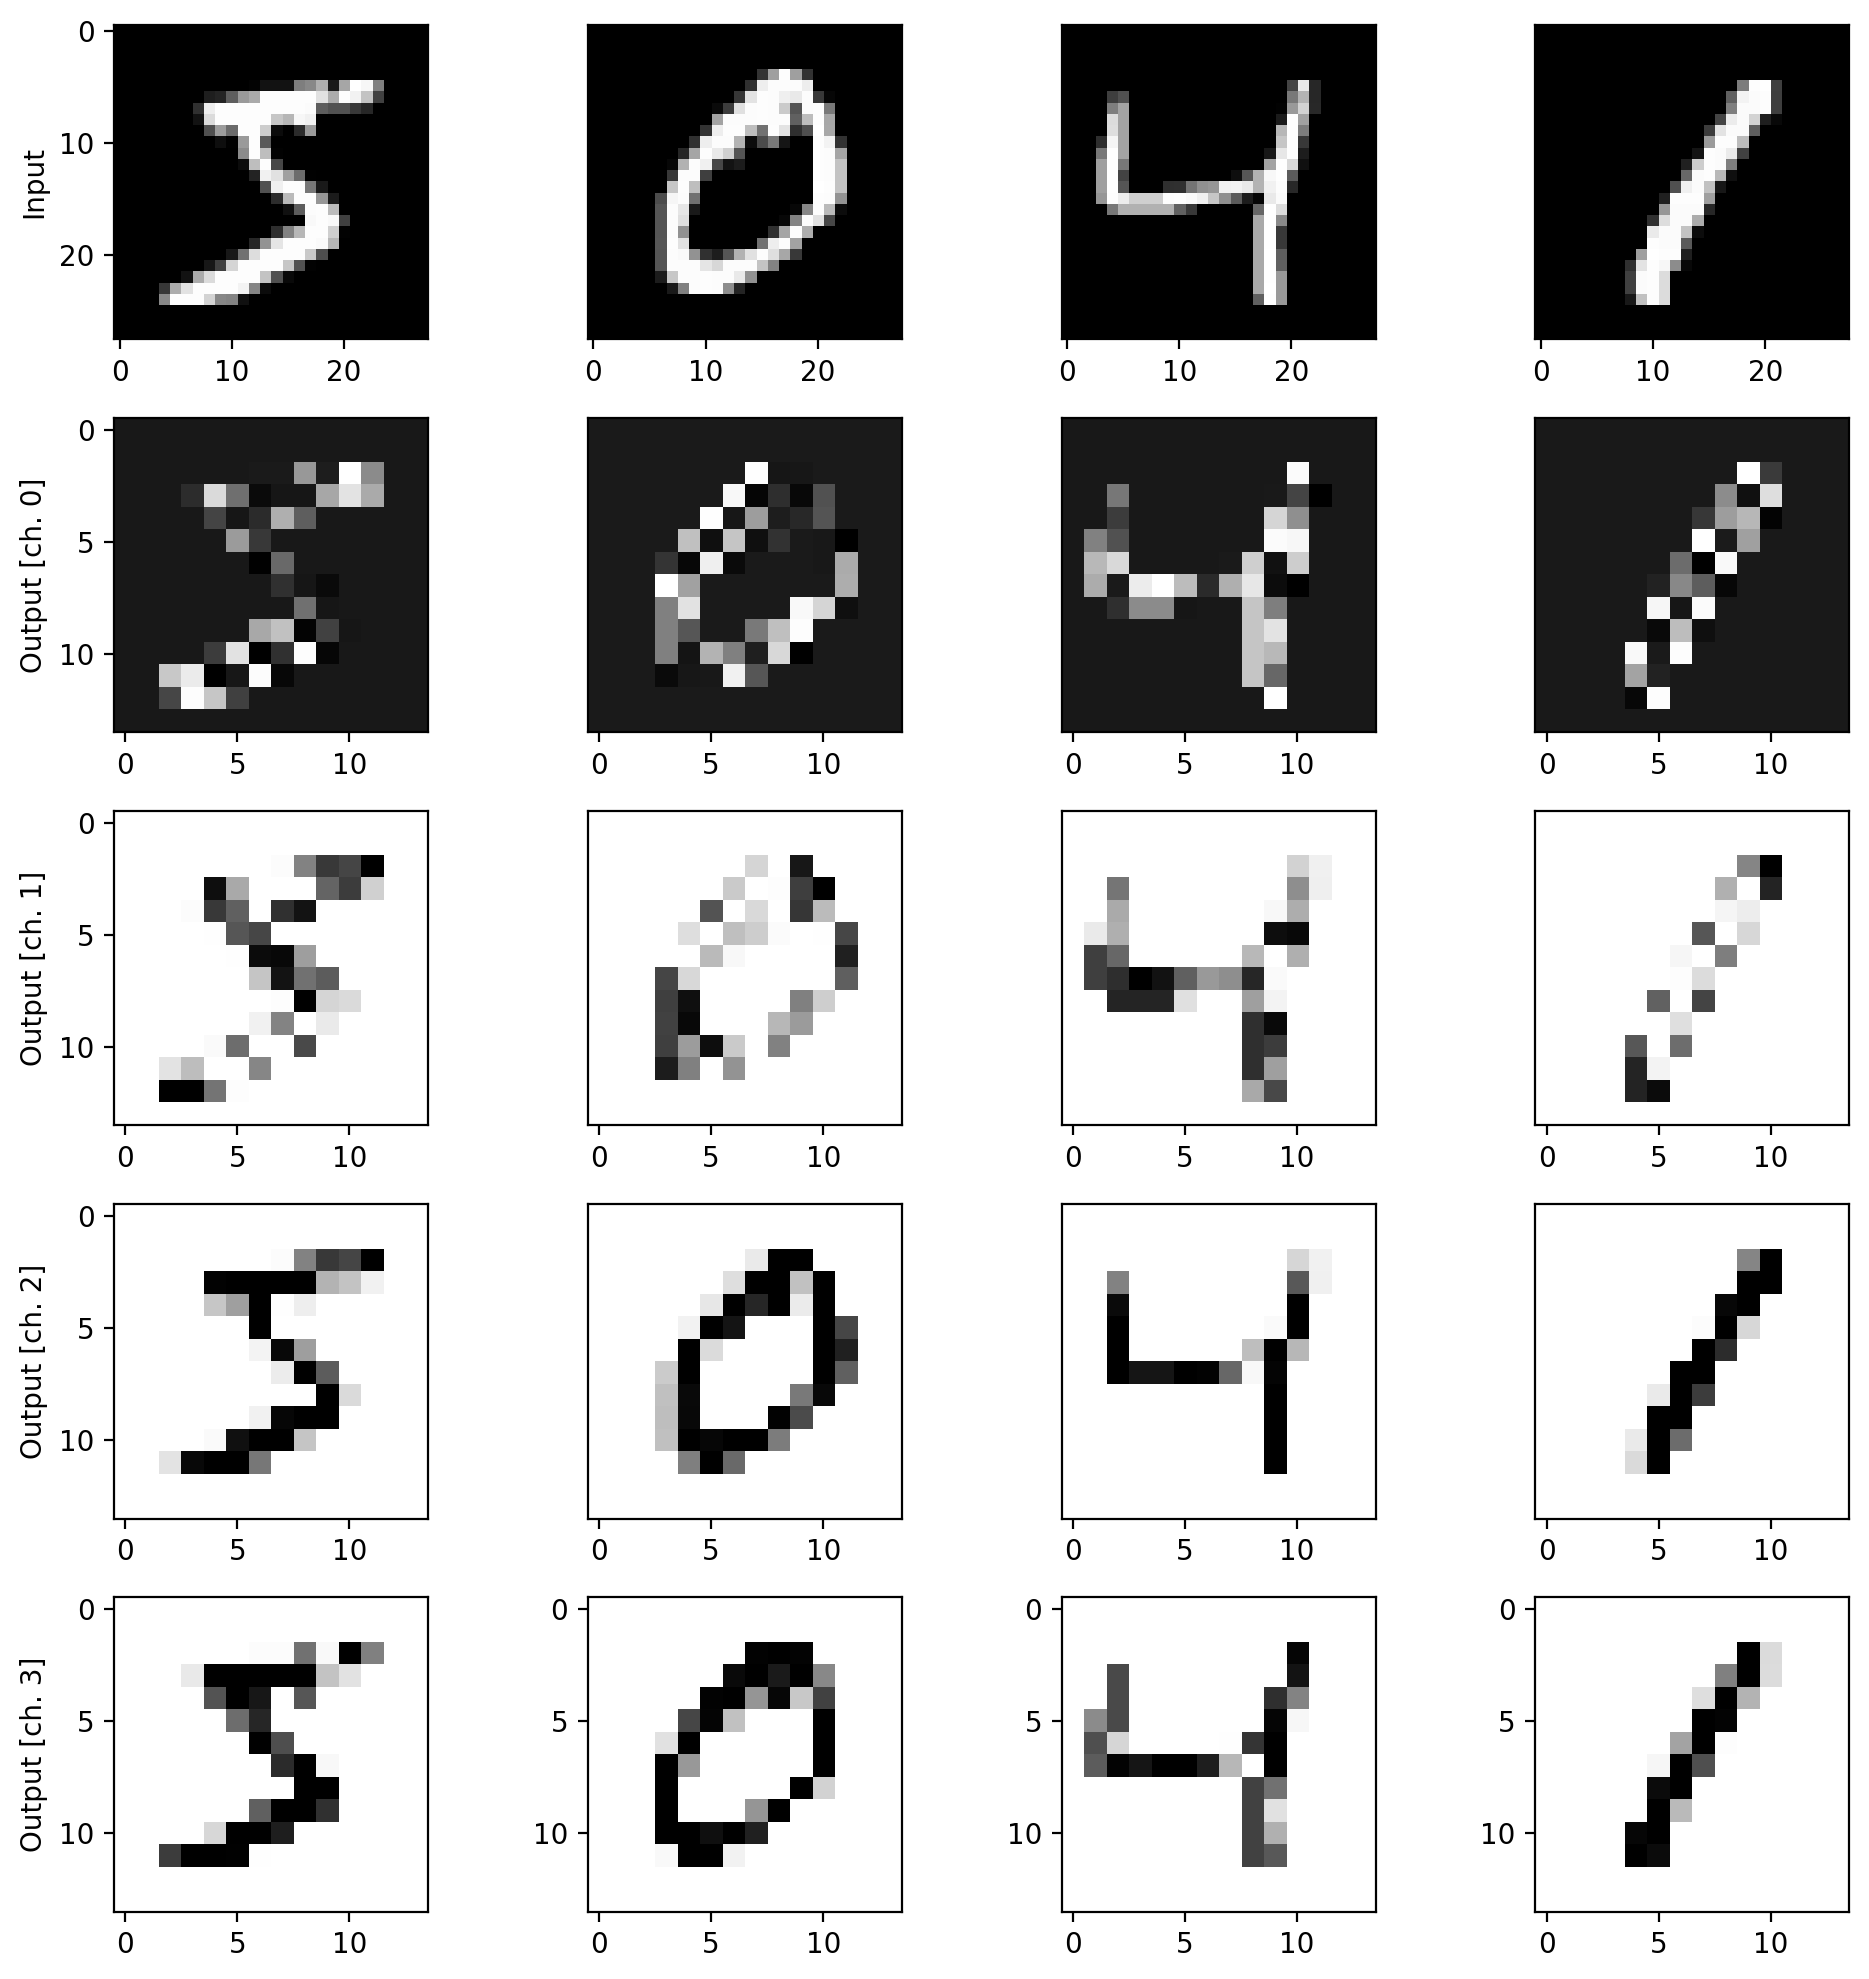

In [7]:
n_samples = 4
n_channels = n_wires
fig, axes = plt.subplots(1 + n_channels, n_samples, figsize=(10, 10))

for k in range(n_samples):
    axes[0, 0].set_ylabel("Input")
    if k != 0:
        axes[0, k].yaxis.set_visible(False)
    axes[0, k].imshow(train_images[k, :, :, 0], cmap="gray")

    # Отрисовка
    for c in range(n_channels):
        axes[c + 1, 0].set_ylabel(f"Output [ch. {c}]")
        if k != 0:
            axes[c, k].yaxis.set_visible(False)
        axes[c + 1, k].imshow(q_train_images[k, :, :, c], cmap="gray")

plt.tight_layout()
plt.show()

По обработанным данным (последние 4 ряда) видно уменьшение разрешения в 2 раза, а также то, что пространственная структура цифр сохраняется, что и должно наблюдаться для сверточных слоев

## Гибридная квантово-классическая модель

Ниже опишем классическую часть нейронной сети, которая будет обучена для классификации 10 цифр. Будет использована очень простая модель, основанная на одном полносвязном слое и финальном применении функции softmax, которая выдает вероятности представленных 10 классов.

Обучение будет осуществлено с помощью оптимизатора `Adam` по функции потерь, в качестве которой используется кросс-энтропия.

In [8]:
def MyModel():
    """Функция инициализирует и возвращает keras модель, готовая к обучению"""

    model = keras.models.Sequential([
        keras.layers.Flatten(),
        keras.layers.Dense(10, activation="softmax")
    ])

    model.compile(
        optimizer='adam',
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )
    return model

## Тренировка моделей

Сначала обучим модель на данных, подготовленных с помощью квантовой цепи.

In [9]:
q_model = MyModel()

q_history = q_model.fit(
    q_train_images,
    train_labels,
    validation_data=(q_test_images, test_labels),
    batch_size=4,
    epochs=n_epochs,
    verbose=0,
)

Для сравнения с результатами чисто классической модели проведем ее обучение на входных необработанных картинках.

In [10]:
c_model = MyModel()

c_history = c_model.fit(
    train_images,
    train_labels,
    validation_data=(test_images, test_labels),
    batch_size=4,
    epochs=n_epochs,
    verbose=0,
)

## Сравнение результатов

Сравнение проведем на основе тестовой точности и значению функции потерь в зависимости от номера эпохи

/tmp/ipykernel_4478/1050205299.py:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn")


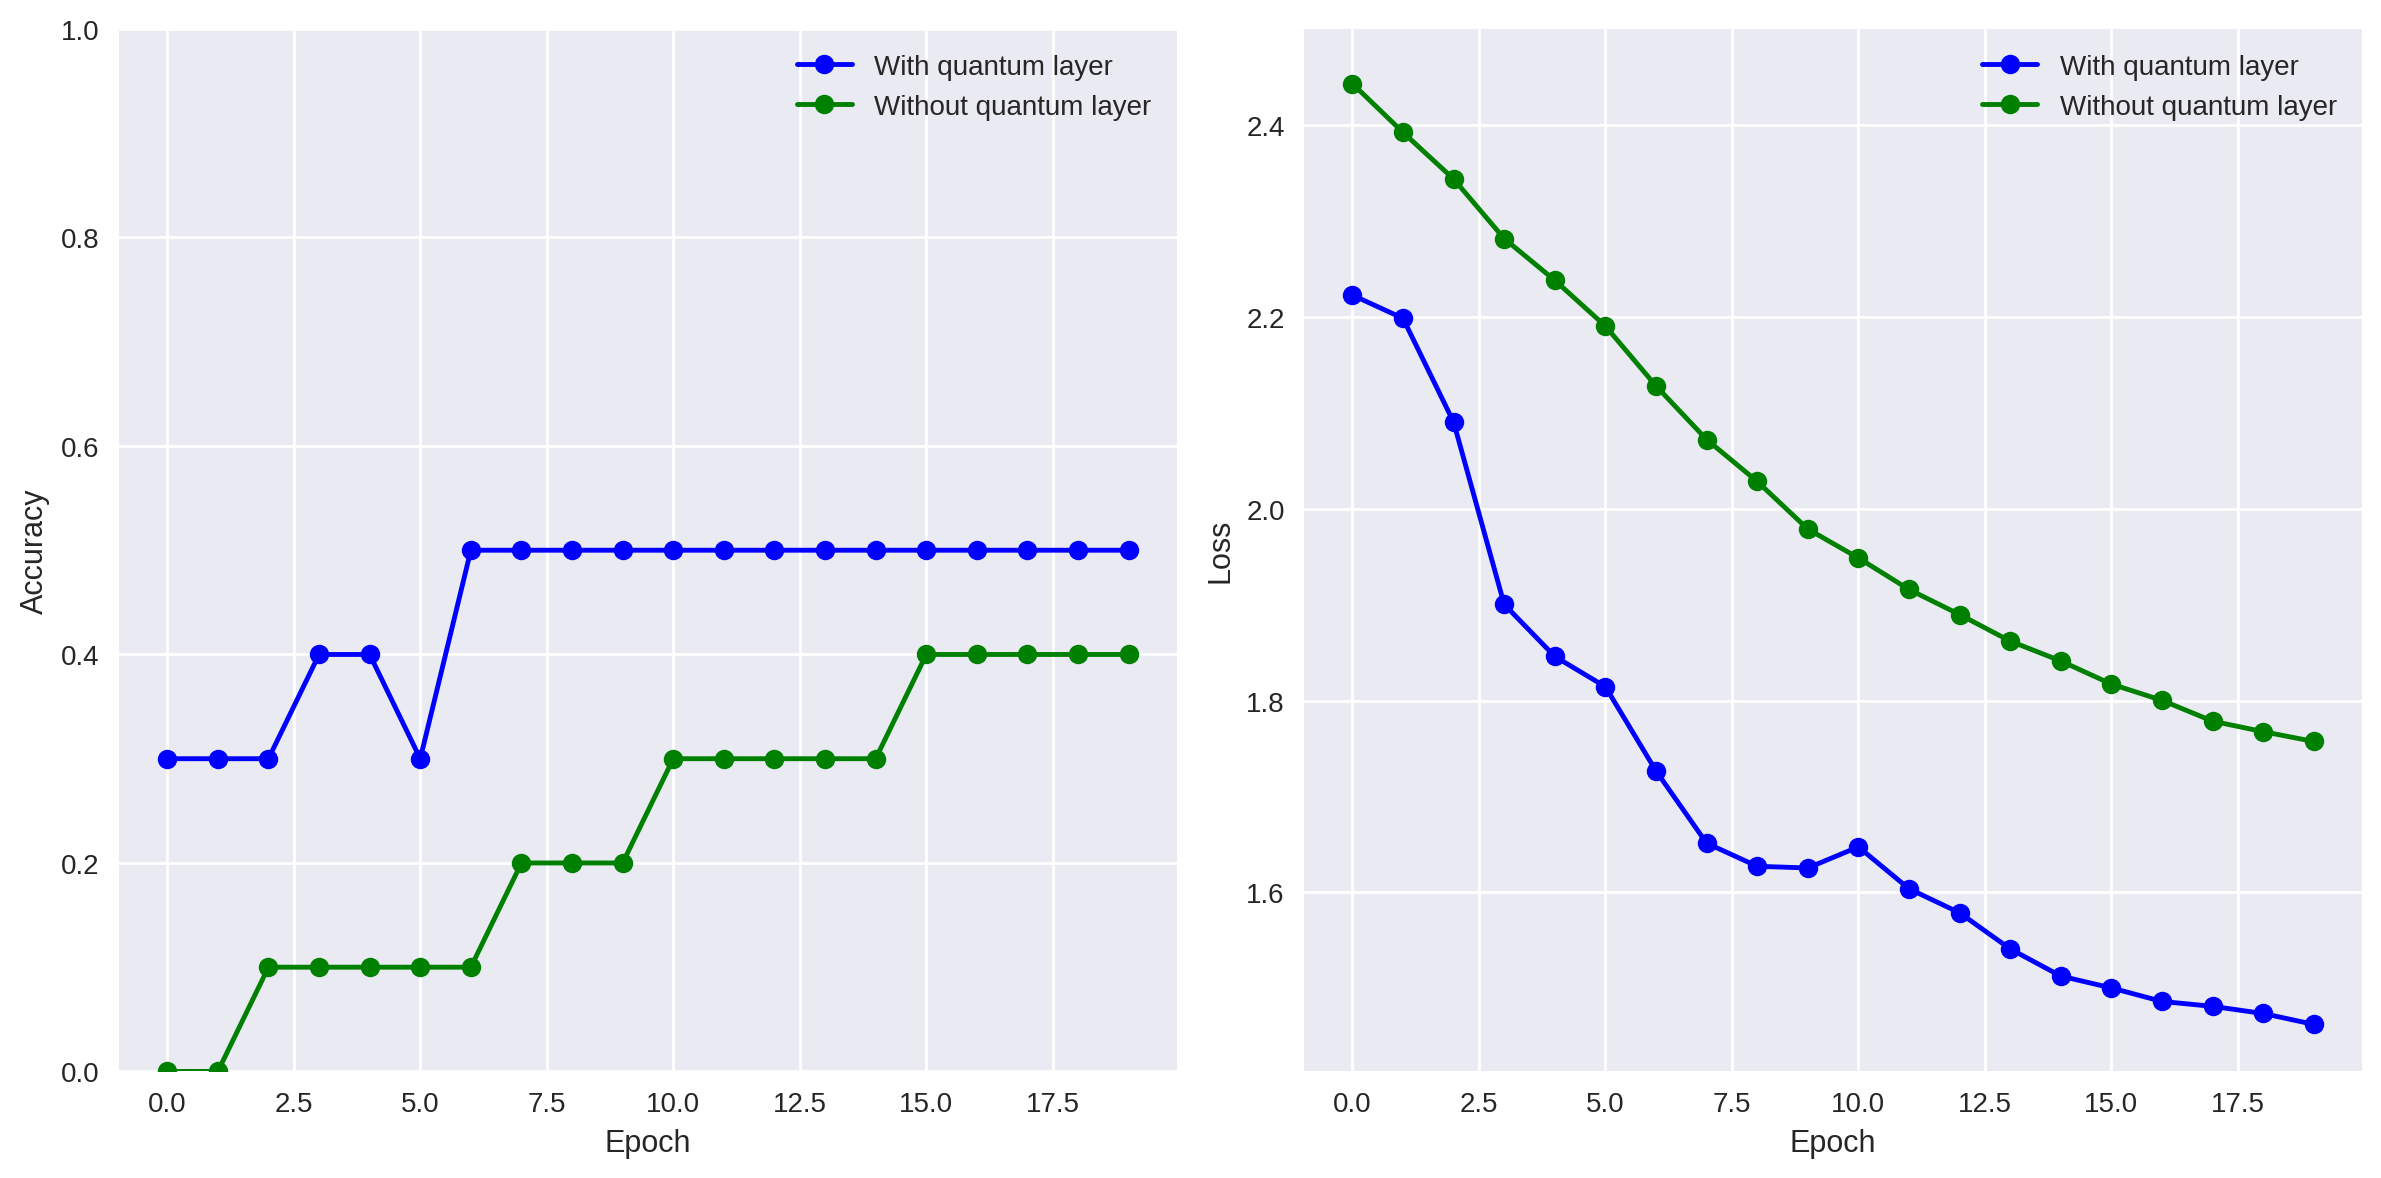

In [11]:
plt.style.use("seaborn")
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

ax1.plot(q_history.history["val_accuracy"], "-ob", label="With quantum layer")
ax1.plot(c_history.history["val_accuracy"], "-og", label="Without quantum layer")
ax1.set_ylabel("Accuracy")
ax1.set_ylim([0, 1])
ax1.set_xlabel("Epoch")
ax1.legend()

ax2.plot(q_history.history["val_loss"], "-ob", label="With quantum layer")
ax2.plot(c_history.history["val_loss"], "-og", label="Without quantum layer")
ax2.set_ylabel("Loss")
ax2.set_ylim(top=2.5)
ax2.set_xlabel("Epoch")
ax2.legend()
plt.tight_layout()
plt.show()

Из рисунков видно наличие сильного сходства результатов для двух моделей: гибридной и чисто классической. В наших малых экспериментах достигнута довольно низкая точность в 50% (классический аналог - 40%). Однако при увеличении числа используемых примеров точность должна быть существенно выше.

## Замечания

- в статье авторов подхода [(Henderson M. et.al., 2019)](https://arxiv.org/abs/1904.04767) для гибридной и чисто классической сети с большим количеством слоев (см. схему сети) и большим объемом данных, достигнута ожидаемая высокая точность выше 95%;
- блоки квантовой свертки сейчас особо интересны, так как они ориентированы на использование малого количества кубитов, которое доступно в текущий период времени для устройств с промежуточным количеством кубитов (NISQ).

## Что мы узнали из лекции

- существует аналог сверточных нейронных сетей для квантовых вычислений;
- аналог квантовой свертки может быть реализован с использованием случайной квантовой цепи;
- использование квантовой свертки позволяет достичь результатов схожих с классическими сетями;
- основное преимущество квантовой свертки по отношению к классической в том, что первая является более широкой операцией, которая не может быть описана классическим случаем.